In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


!pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
!pip install -U pandas

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import time

# Essential DS libraries
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


In [30]:
!pip install biopandas
from biopandas.pdb import PandasPdb

pl1 = PandasPdb().read_pdb('/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb')
pl1.df

{'ATOM':      record_name  atom_number blank_1 atom_name alt_loc residue_name blank_2  \
 0           ATOM            1                 N                  VAL           
 1           ATOM            2                 H                  VAL           
 2           ATOM            3                H2                  VAL           
 3           ATOM            4                H3                  VAL           
 4           ATOM            5                CA                  VAL           
 ...          ...          ...     ...       ...     ...          ...     ...   
 3312        ATOM         3313                NZ                  LYS           
 3313        ATOM         3314               HZ1                  LYS           
 3314        ATOM         3315               HZ2                  LYS           
 3315        ATOM         3316               HZ3                  LYS           
 3316        ATOM         3317               OXT                  LYS           
 
      chain_id  re

In [31]:
df_train = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/train.csv")
df_test = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/test.csv")
df_train_up = pd.read_csv("/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv")

In [32]:
drop_seq_ids = df_train_up[df_train_up.isnull().sum(axis=1)==4]['seq_id']
df_train = df_train[~df_train.seq_id.isin(drop_seq_ids)]
replace_seq_ids = df_train_up.loc[df_train_up.isnull().sum(axis=1)!=4,"seq_id"]
df_train = df_train[~df_train.seq_id.isin(replace_seq_ids)]
correct_df = df_train_up[df_train_up.isnull().sum(axis=1)!=4]
df_train = pd.concat([df_train, correct_df], ignore_index=True)

In [33]:
# Top 2 chars features (most frequent)
cols2 = ['aa',
 'ae',
 'ag',
 'ai',
 'ak',
 'al',
 'as',
 'av',
 'da',
 'de',
 'dl',
 'ea',
 'ed',
 'ee',
 'eg',
 'ek',
 'el',
 'er',
 'es',
 'ev',
 'ga',
 'ge',
 'gg',
 'gk',
 'gl',
 'gs',
 'gv',
 'ia',
 'il',
 'ka',
 'ke',
 'kk',
 'kl',
 'ks',
 'la',
 'ld',
 'le',
 'lg',
 'li',
 'lk',
 'll',
 'ln',
 'lp',
 'lq',
 'lr',
 'ls',
 'lt',
 'lv',
 'pe',
 'pl',
 'ps',
 'ql',
 'rl',
 'sa',
 'se',
 'sg',
 'sk',
 'sl',
 'sp',
 'ss',
 'st',
 'sv',
 'ta',
 'tl',
 'ts',
 'va',
 've',
 'vl',
 'vs',
 'vv']
# Top 3 chars features (most frequent)
cols3 = ['aaa',
 'aae',
 'aag',
 'aal',
 'aas',
 'aav',
 'aea',
 'aee',
 'ael',
 'agl',
 'ala',
 'ale',
 'alg',
 'alk',
 'all',
 'alr',
 'als',
 'asl',
 'ass',
 'ava',
 'avl',
 'dee',
 'dll',
 'eaa',
 'eae',
 'eal',
 'eea',
 'eee',
 'eek',
 'eel',
 'ekl',
 'ela',
 'ele',
 'elk',
 'ell',
 'erl',
 'esl',
 'evl',
 'ggg',
 'ggs',
 'gla',
 'gll',
 'gsg',
 'gss',
 'kal',
 'kel',
 'kkl',
 'kll',
 'laa',
 'lae',
 'lag',
 'lak',
 'lal',
 'las',
 'ldl',
 'lea',
 'lee',
 'lek',
 'lel',
 'lgl',
 'lka',
 'lke',
 'lkk',
 'lla',
 'lld',
 'lle',
 'llg',
 'llk',
 'lll',
 'llq',
 'llr',
 'lls',
 'llt',
 'llv',
 'lre',
 'lrl',
 'lsa',
 'lse',
 'lsg',
 'lsl',
 'lss',
 'lvl',
 'qll',
 'rll',
 'saa',
 'sal',
 'sas',
 'sgs',
 'sla',
 'sll',
 'sls',
 'ssa',
 'ssg',
 'ssl',
 'sss',
 'tll',
 'vaa',
 'vla',
 'vll']
# Top 4 chars features (most frequent)
cols4 = ['aaaa',
 'aaal',
 'aaas',
 'aaav',
 'aaga',
 'aala',
 'aalg',
 'aall',
 'aavr',
 'aeal',
 'alaa',
 'alal',
 'alea',
 'alga',
 'alke',
 'alla',
 'alle',
 'alll',
 'asss',
 'avaa',
 'deee',
 'eaaa',
 'eaal',
 'eaav',
 'eaek',
 'eala',
 'eale',
 'ealk',
 'eall',
 'ealr',
 'eeal',
 'eeea',
 'eeed',
 'eeee',
 'eeek',
 'eeel',
 'eele',
 'eelk',
 'eell',
 'elae',
 'elar',
 'elee',
 'ella',
 'elle',
 'ellk',
 'erlr',
 'gggg',
 'gggs',
 'gsss',
 'klle',
 'laaa',
 'laal',
 'laek',
 'lael',
 'laks',
 'lala',
 'lall',
 'leaa',
 'leal',
 'leea',
 'leee',
 'leel',
 'lekl',
 'lell',
 'lkal',
 'lkel',
 'lkkl',
 'llaa',
 'llae',
 'llal',
 'llea',
 'llee',
 'llek',
 'llel',
 'llke',
 'llla',
 'llle',
 'llll',
 'lllv',
 'llsa',
 'llsl',
 'lltk',
 'lrlk',
 'lsal',
 'lsll',
 'lssl',
 'lsss',
 'lvll',
 'rlll',
 'saaa',
 'sall',
 'sass',
 'sgse',
 'sgss',
 'slss',
 'ssas',
 'ssgs',
 'ssls',
 'sssa',
 'sssg',
 'sssl',
 'ssss',
 'ssst',
 'vaaa',
 'vlls']
# Top 5 chars features (most frequent)
cols5 = ['aaaaa',
 'aaaag',
 'aaaal',
 'aaaas',
 'aaaat',
 'aaaav',
 'aaala',
 'aaava',
 'aalaa',
 'aalgf',
 'aavrg',
 'aleal',
 'algal',
 'allea',
 'assss',
 'avaaa',
 'deeed',
 'deeee',
 'eaaaa',
 'eaavn',
 'eaekl',
 'ealke',
 'eeale',
 'eeedd',
 'eeede',
 'eeeed',
 'eeeee',
 'eeeek',
 'eelkk',
 'elaek',
 'elart',
 'erlrl',
 'ggggg',
 'ggggs',
 'gggsg',
 'gssss',
 'laekl',
 'laksi',
 'lealk',
 'lllvd',
 'llsag',
 'llsll',
 'lltks',
 'lrlki',
 'lsssa',
 'lssss',
 'lsssy',
 'lvlll',
 'lvlls',
 'rlllv',
 'saaaa',
 'sallq',
 'sasss',
 'sgsea',
 'sgsed',
 'sgsss',
 'slsss',
 'ssass',
 'ssgss',
 'sslss',
 'sssan',
 'sssas',
 'sssgg',
 'sssgs',
 'ssssa',
 'ssssd',
 'ssssg',
 'ssssl',
 'sssss',
 'sssst',
 'sssts',
 'vaaaa',
 'vllsl',
 'vllsv']

In [34]:
df_train

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...
28976,1122,DVSGTVCLSALPPEAVDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
28977,1125,DVSGVVCLSALPPEATDTLNLIASDGPFPYSQDGVVFQNRESVLPT...,7.0,NaN,48.4
28978,13447,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,2.7,NaN,64.9
28979,13449,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,2.7,NaN,64.9


Perhaps we should add reversed sequences to the dataset?

In [35]:
# Adding reversed protein sequences

df_train1 = df_train.copy()
df_train1.protein_sequence = df_train1.protein_sequence.apply(lambda x: x[::-1])
df_train = pd.concat([df_train, df_train1])

In [36]:
df_train = df_train.drop('data_source', axis=1)
df_test = df_test.drop('data_source', axis=1)

In [37]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

X=df_train.copy()
X=X.dropna()
X['len']=X['protein_sequence'].str.len()
X=X.query('0<=pH<=14')
X['M_weight']=X['protein_sequence'].apply(lambda r :  ProteinAnalysis(r).molecular_weight())
df_train = X

X=df_test.copy()
X=X.dropna()
X['len']=X['protein_sequence'].str.len()
X=X.query('0<=pH<=14')
X['M_weight']=X['protein_sequence'].apply(lambda r :  ProteinAnalysis(r).molecular_weight())
df_test = X

In [38]:
from string import ascii_lowercase

for char in ascii_lowercase:
    df_train[char] = df_train.protein_sequence.apply(lambda x: x.lower().count(char))
    df_test[char] = df_test.protein_sequence.apply(lambda x: x.lower().count(char))
    
for col in cols2:
    df_train[col] = df_train.protein_sequence.apply(lambda x: x.lower().count(col)) 
    df_test[col] = df_test.protein_sequence.apply(lambda x: x.lower().count(col)) 
    
# for col in cols3:
#     df_train[col] = df_train.protein_sequence.apply(lambda x: x.lower().count(col)) 
#     df_test[col] = df_test.protein_sequence.apply(lambda x: x.lower().count(col)) 

In [39]:
df_train

,seq_id,protein_sequence,pH,tm,len,M_weight,a,b,c,d,...,st,sv,ta,tl,ts,va,ve,vl,vs,vv
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,36320.7244,45,0,1,13,...,1,3,1,1,1,2,1,3,1,6
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,32837.9931,28,0,0,10,...,0,0,0,1,0,2,1,1,2,2
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,53428.8034,50,0,9,27,...,4,0,2,1,2,1,2,2,2,1
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,29475.5996,20,0,5,19,...,2,1,2,2,1,1,3,1,1,1
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5,1451,158761.9814,86,0,14,78,...,10,10,4,11,13,7,5,5,8,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28976,1122,CTQDILSFTAYHDGTYYDEQTAEGTIIRRTGRTRAGPTIVTYEHYY...,7.0,48.4,96,10573.4557,6,0,2,7,...,0,1,2,0,0,1,0,0,1,1
28977,1125,CTQDILSFTAYHDGTYYDEQTAEGTIIRRTGRTRAGPTIVTYEHYY...,7.0,48.4,96,10573.4557,6,0,2,7,...,0,1,3,0,0,0,0,0,1,2
28978,13447,VGCGQVYQRVDRAQCRNRWAVWARIGQPDRVVRKACAVADAINDQL...,2.7,64.9,148,16493.8303,16,0,8,8,...,0,0,1,0,1,2,0,1,1,1
28979,13449,VGCGQVYQRVDRGQCRNRWAVWARIGQPDRVVRKACAVADAINDQL...,2.7,64.9,148,16479.8037,15,0,8,8,...,0,0,1,0,1,2,0,1,1,1


In [40]:
pca_cols = [col for col in df_train.columns]
pca_cols.remove('seq_id')
pca_cols.remove('protein_sequence')
pca_cols.remove('tm')

In [41]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

df_train[pca_cols] = scaler.fit_transform(df_train[pca_cols])
df_test[pca_cols] = scaler.transform(df_test[pca_cols])

In [42]:
from sklearn.decomposition import PCA
two_d_transform = PCA(2)

two_d_transform.fit(df_train[pca_cols])
df_train_2d = two_d_transform.transform(df_train[pca_cols])
df_test_2d = two_d_transform.transform(df_test[pca_cols])

<AxesSubplot:xlabel='0', ylabel='1'>

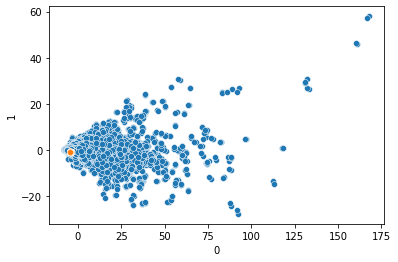

In [43]:
import seaborn as sns
df_train_2d = pd.DataFrame(df_train_2d)
df_test_2d = pd.DataFrame(df_test_2d)
sns.scatterplot(data = df_train_2d, x=df_train_2d[0], y=df_train_2d[1])
sns.scatterplot(data = df_test_2d, x=df_test_2d[0], y=df_test_2d[1])

In [44]:
df_train

,seq_id,protein_sequence,pH,tm,len,M_weight,a,b,c,d,...,st,sv,ta,tl,ts,va,ve,vl,vs,vv
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,0.160789,75.7,-0.265613,-0.302593,0.323799,0.0,-0.553978,-0.484445,...,-0.285269,0.368118,-0.333766,-0.465085,-0.285269,-0.128596,-0.412538,0.100347,-0.391944,1.859633
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,0.160789,50.5,-0.397545,-0.377409,-0.200338,0.0,-0.652411,-0.604088,...,-0.649220,-0.771975,-0.758938,-0.465085,-0.649220,-0.128596,-0.412538,-0.554371,-0.011913,0.050133
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,0.160789,40.5,0.108593,0.064923,0.477957,0.0,0.233489,0.073887,...,0.806583,-0.771975,0.091406,-0.465085,0.078682,-0.511264,-0.024605,-0.227012,-0.011913,-0.402243
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,0.160789,47.2,-0.447919,-0.449640,-0.446991,0.0,-0.160245,-0.245160,...,0.078682,-0.391944,0.091406,-0.105176,-0.285269,-0.511264,0.363328,-0.554371,-0.391944,-0.402243
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,0.160789,49.5,2.397007,2.327690,1.587895,0.0,0.725656,2.107812,...,2.990286,3.028336,0.941749,3.134005,4.082138,1.784744,1.139194,0.755064,2.268274,5.026260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28976,1122,CTQDILSFTAYHDGTYYDEQTAEGTIIRRTGRTRAGPTIVTYEHYY...,0.160789,48.4,-0.853309,-0.855696,-0.878633,0.0,-0.455545,-0.723731,...,-0.649220,-0.391944,0.091406,-0.824994,-0.649220,-0.511264,-0.800471,-0.881730,-0.391944,-0.402243
28977,1125,CTQDILSFTAYHDGTYYDEQTAEGTIIRRTGRTRAGPTIVTYEHYY...,0.160789,48.4,-0.853309,-0.855696,-0.878633,0.0,-0.455545,-0.723731,...,-0.649220,-0.391944,0.516577,-0.824994,-0.649220,-0.893932,-0.800471,-0.881730,-0.391944,0.050133
28978,13447,VGCGQVYQRVDRAQCRNRWAVWARIGQPDRVVRKACAVADAINDQL...,-5.260494,64.9,-0.728573,-0.728514,-0.570317,0.0,0.135056,-0.683850,...,-0.649220,-0.771975,-0.333766,-0.824994,-0.285269,-0.128596,-0.800471,-0.554371,-0.391944,-0.402243
28979,13449,VGCGQVYQRVDRGQCRNRWAVWARIGQPDRVVRKACAVADAINDQL...,-5.260494,64.9,-0.728573,-0.728816,-0.601149,0.0,0.135056,-0.683850,...,-0.649220,-0.771975,-0.333766,-0.824994,-0.285269,-0.128596,-0.800471,-0.554371,-0.391944,-0.402243


In [45]:
# max_len = df_train.len.max()
# max_len_test = df_test.len.max()

# df_train.protein_sequence = df_train.protein_sequence.apply(lambda x: x.ljust(max_len, '0'))
# df_test.protein_sequence = df_test.protein_sequence.apply(lambda x: x.ljust(max_len, '0'))

Thanks to @sgreiner for LSTM model!) https://www.kaggle.com/code/sgreiner/novo-esp-lstm (link for upvoting :))


Some feature engineering (from @sgreiner notebook - https://www.kaggle.com/code/sgreiner/novo-esp-lstm)

In [46]:
char_seq = {'A': 0}

max_seq = 0

def get_char_index(c):
    
    if c in char_seq.keys():
        return char_seq[c]
    else:
        char_seq[c] = len(char_seq)
    
    return len(char_seq)
        
    
def to_seq(string):
    
    new_seq = [get_char_index(c) for c in string]
    
    return new_seq

def get_counts(seq):
    
    counts = np.zeros(len(char_seq) + 1)
    
    for i, c in enumerate(char_seq.keys()):
        counts[i] = sum([x == c for x in seq]) / len(seq)
        
    counts[len(char_seq)] = len(seq) / 1_000
        
    return counts

def create_features(df):
    
    df['seq'] = df['protein_sequence'].apply(to_seq)
    
#     df['counts'] = df['protein_sequence'].apply(get_counts)
        
    print(len(char_seq))

    return df

In [47]:
# df_train = create_features(df_train)
# df_test = create_features(df_test)

In [48]:
y_train = df_train['tm'].values

# df_train = df_train.drop(['protein_sequence', 'tm'], axis=1)
df_train = df_train.drop('protein_sequence', axis=1)
df_test = df_test.drop('protein_sequence', axis=1)

In [49]:
df_train

,seq_id,pH,tm,len,M_weight,a,b,c,d,e,...,st,sv,ta,tl,ts,va,ve,vl,vs,vv
0,0,0.160789,75.7,-0.265613,-0.302593,0.323799,0.0,-0.553978,-0.484445,-0.075671,...,-0.285269,0.368118,-0.333766,-0.465085,-0.285269,-0.128596,-0.412538,0.100347,-0.391944,1.859633
1,1,0.160789,50.5,-0.397545,-0.377409,-0.200338,0.0,-0.652411,-0.604088,0.539722,...,-0.649220,-0.771975,-0.758938,-0.465085,-0.649220,-0.128596,-0.412538,-0.554371,-0.011913,0.050133
2,2,0.160789,40.5,0.108593,0.064923,0.477957,0.0,0.233489,0.073887,-0.019726,...,0.806583,-0.771975,0.091406,-0.465085,0.078682,-0.511264,-0.024605,-0.227012,-0.011913,-0.402243
3,3,0.160789,47.2,-0.447919,-0.449640,-0.446991,0.0,-0.160245,-0.245160,-0.103644,...,0.078682,-0.391944,0.091406,-0.105176,-0.285269,-0.511264,0.363328,-0.554371,-0.391944,-0.402243
4,4,0.160789,49.5,2.397007,2.327690,1.587895,0.0,0.725656,2.107812,1.267006,...,2.990286,3.028336,0.941749,3.134005,4.082138,1.784744,1.139194,0.755064,2.268274,5.026260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28976,1122,0.160789,48.4,-0.853309,-0.855696,-0.878633,0.0,-0.455545,-0.723731,-0.774982,...,-0.649220,-0.391944,0.091406,-0.824994,-0.649220,-0.511264,-0.800471,-0.881730,-0.391944,-0.402243
28977,1125,0.160789,48.4,-0.853309,-0.855696,-0.878633,0.0,-0.455545,-0.723731,-0.774982,...,-0.649220,-0.391944,0.516577,-0.824994,-0.649220,-0.893932,-0.800471,-0.881730,-0.391944,0.050133
28978,13447,-5.260494,64.9,-0.728573,-0.728514,-0.570317,0.0,0.135056,-0.683850,-0.830927,...,-0.649220,-0.771975,-0.333766,-0.824994,-0.285269,-0.128596,-0.800471,-0.554371,-0.391944,-0.402243
28979,13449,-5.260494,64.9,-0.728573,-0.728816,-0.601149,0.0,0.135056,-0.683850,-0.830927,...,-0.649220,-0.771975,-0.333766,-0.824994,-0.285269,-0.128596,-0.800471,-0.554371,-0.391944,-0.402243


In [50]:
# for i in range(max_len):
#     df_train['seq'+str(i)] = df_train['seq'].apply(lambda x: x[i])
#     df_test['seq'+str(i)] = df_test['seq'].apply(lambda x: x[i])

In [51]:
# df_train = df_train.drop('seq', axis=1)
# df_test = df_test.drop('seq', axis=1)

In [52]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()

# df_train[['pH', 'len', 'M_weight']] = scaler.fit_transform(df_train[['pH', 'len', 'M_weight']])
# df_test[['pH', 'len', 'M_weight']] = scaler.transform(df_test[['pH', 'len', 'M_weight']])

In [53]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 60 * 120 
TARGET_NAME = 'tm'

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [54]:
task = Task('reg', loss = 'mse', metric = 'mse')

In [55]:
roles = {
    'target': TARGET_NAME, 
#     'text': 'protein_sequence'
}

In [56]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned'],['lgb_tuned', 'cb'],['lgb_tuned']]},
#     selection_params = {'mode': 2, 'feature_group_size': 50, 'select_algos': ['linear_l2', 'gbm']},
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [57]:
pred_tr = automl.fit_predict(df_train, roles=roles, verbose = 1)

[12:46:43] Start automl utilizator with listed constraints:
[12:46:43] - time: 7200.00 seconds
[12:46:43] - CPU: 4 cores
[12:46:43] - memory: 16 GB

[12:46:43] If one preset completes earlier, next preset configuration will be started

[12:46:43] ==================================================
[12:46:43] Start 0 automl preset configuration:
[12:46:43] conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[12:46:43] Stdout logging level is INFO.
[12:46:43] Task: reg

[12:46:43] Start automl preset with listed constraints:
[12:46:43] - time: 7200.00 seconds
[12:46:43] - CPU: 4 cores
[12:46:43] - memory: 16 GB

[12:46:43] Train data shape: (57390, 101)

[12:46:53] Layer 1 train process start. Time left 7189.37 secs
[12:46:59] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[12:47:17] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = -99.2534179448177
[12:47:17] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicti

KeyboardInterrupt: 

In [ ]:
pred_tr = pred_tr.data[:,0]

In [ ]:
pd.Series(pred_tr).plot.hist()

In [ ]:
pred = automl.predict(df_test)
pred = pred.data[:,0]

In [ ]:
pd.Series(pred).plot.hist()

In [ ]:
df_test['tm'] = pred
df_test.reset_index()[['seq_id','tm']].to_csv('submission.csv', index=False)


In [ ]:
df_test.reset_index()[['seq_id','tm']]